In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
%matplotlib inline

# Функции разбиения

In [2]:
def split_border(nodes, n, closed_contour=False):
    result = np.array([])
    
    ln = nodes.shape[0]-1
    
    for i in range(nodes.shape[0]-1):
        res_xs = np.linspace(nodes[i,0], nodes[i+1,0], n)[:-1]
        res_ys = np.linspace(nodes[i,1], nodes[i+1,1], n)[:-1]
        result = np.append(result, np.hstack((np.array(res_xs).reshape(-1,1), np.array(res_ys).reshape(-1,1))))

    if not closed_contour and n:
        result = np.append(result, np.hstack((np.array(nodes[:,0][-1]).reshape(-1,1), np.array(nodes[:,1][-1]).reshape(-1,1))))
        
    return result.reshape(-1, 2)

In [3]:
def gen_arc(center, R, alpha1, alpha2, n):
    alpha1 = np.radians(np.linspace(alpha1, alpha2, n))

    x1 = R * np.cos(alpha1) + center[0]
    y1 = R * np.sin(alpha1) + center[1]
    
    return np.hstack((x1.reshape(-1, 1), y1.reshape(-1, 1)))

# Константы задачи

In [4]:
SPLITNUM = 20

In [5]:
L = 15
H = 1
R = 200
t = 4 # Толщина

In [6]:
# Сталь №3
E = 2.2e7 # 220 ГПа в H/см^2
mu = 0.31

In [7]:
stp = np.array((0., 0.)) # Starting point

# Функции отрисовки

In [8]:
def make_plot_nicer(plt, scale_x=1., scale_y=10.):
    SCALE_COEFF_X = scale_x
    SCALE_COEFF_Y = scale_y
    
    my_xticks = np.array(np.linspace(stp[0], stp[0] + L, SPLITNUM))
    my_yticks = np.array(np.linspace(stp[1], stp[1] + H, SPLITNUM))
    plt.xticks(my_xticks*SCALE_COEFF_X, np.around(my_xticks, 2))
    plt.yticks(my_yticks*SCALE_COEFF_Y, np.around(my_yticks, 2))
    
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.axis('equal')
    plt.grid(True)

In [9]:
def plotfig_simple(fig_pts, scale_x=1., scale_y=10., draw_coord_lines=False):
    # Because R is ~20 times bigger than L,
    # we will be defining some scale coefficients
    # just for plotting
    SCALE_COEFF_X = scale_x
    SCALE_COEFF_Y = scale_y
    
    if draw_coord_lines:
        plt.axhline(0., c='r')
        plt.axvline(0., c='r')
    
    plt.plot(fig_pts[:,0]*SCALE_COEFF_X, fig_pts[:,1]*SCALE_COEFF_Y, '.-')

    make_plot_nicer(plt, SCALE_COEFF_X, SCALE_COEFF_Y)

In [10]:
def plotfig_mesh(mesh_pts, fig_pts=None, scale_x=1., scale_y=10., draw_coord_lines=False):
    SCALE_COEFF_X = scale_x
    SCALE_COEFF_Y = scale_y
    
    if draw_coord_lines:
        plt.axhline(0., c='r')
        plt.axvline(0., c='r')
        
    plt.plot(mesh_pts[:,0]*SCALE_COEFF_X, mesh_pts[:,1]*SCALE_COEFF_Y, '.')
    if fig_pts is not None:
        plt.plot(fig_pts[:,0]*SCALE_COEFF_X, fig_pts[:,1]*SCALE_COEFF_Y, 'r.-')
    
    make_plot_nicer(plt, SCALE_COEFF_X, SCALE_COEFF_Y)

In [11]:
def plotfig_trng(Nodes, simplices, fig_pts=None, scale_x=1., scale_y=10., draw_coord_lines=False):
    SCALE_COEFF_X = scale_x
    SCALE_COEFF_Y = scale_y
    
    if draw_coord_lines:
        plt.axhline(0., c='r')
        plt.axvline(0., c='r')
        
    plt.triplot(Nodes[:,0]*SCALE_COEFF_X, Nodes[:,1]*SCALE_COEFF_Y, simplices)
    if fig_pts is not None:
        plt.plot(fig_pts[:,0]*SCALE_COEFF_X, fig_pts[:,1]*SCALE_COEFF_Y, 'r.-')
    
    make_plot_nicer(plt, SCALE_COEFF_X, SCALE_COEFF_Y)

In [12]:
def plotfig_enumerate_border(border_pts=None, scale_x=1., scale_y=10., draw_coord_lines=False):
    SCALE_COEFF_X = scale_x
    SCALE_COEFF_Y = scale_y
    
    if draw_coord_lines:
        plt.axhline(0., c='r')
        plt.axvline(0., c='r')
    
    plt.plot(border_pts[:,0]*SCALE_COEFF_X, border_pts[:,1]*SCALE_COEFF_Y, '.')
    for i, p in enumerate(border_pts):
        plt.text(p[0]*SCALE_COEFF_X, p[1]*SCALE_COEFF_Y, ' %d'%i)
        
    make_plot_nicer(plt, SCALE_COEFF_X, SCALE_COEFF_Y)

In [13]:
def plotfig_enumerate_trng(Nodes, simplices, fig_pts=None, scale_x=1., scale_y=10., draw_coord_lines=False):
    SCALE_COEFF_X = scale_x
    SCALE_COEFF_Y = scale_y
    
    if draw_coord_lines:
        plt.axhline(0., c='r')
        plt.axvline(0., c='r')
    
    plt.plot(Nodes[:,0]*SCALE_COEFF_X, Nodes[:,1]*SCALE_COEFF_Y, 'r.')
    plt.triplot(Nodes[:,0]*SCALE_COEFF_X, Nodes[:,1]*SCALE_COEFF_Y, simplices)
    for i, p in enumerate(Nodes):
        plt.text(p[0]*SCALE_COEFF_X, p[1]*SCALE_COEFF_Y, ' %d'%i)
        
    make_plot_nicer(plt, SCALE_COEFF_X, SCALE_COEFF_Y)

In [14]:
def plot_fancy_thingy(Nodes, simplices, resNodes, NodeS1, fig_pts, fixed_pts, force_pts, levels_cnt=10, scale_x=1., scale_y=10., draw_coord_lines=False):
    SCALE_COEFF_X = scale_x
    SCALE_COEFF_Y = scale_y
    
    if draw_coord_lines:
        plt.axhline(0., c='r')
        plt.axvline(0., c='r')
    
    # Plot original figure border
    plt.plot(fig_pts[:,0]*SCALE_COEFF_X, fig_pts[:,1]*SCALE_COEFF_Y, 'r.-')
    
    lvls = np.linspace(np.min(NodeS1), np.max(NodeS1), levels_cnt)
    
    # Plot contour map of stiffness
    plt.tricontour(resNodes[:, 0]*SCALE_COEFF_X, resNodes[:, 1]*SCALE_COEFF_Y, simplices, NodeS1.ravel(), levels=lvls, colors=('k'))
    contour_plot = plt.tricontourf(resNodes[:, 0]*SCALE_COEFF_X, resNodes[:, 1]*SCALE_COEFF_Y, simplices, NodeS1.ravel(), levels=lvls, cmap='jet')
    plt.gcf().colorbar(contour_plot)
    
    # Plot the text
    for pt_num in fixed_pts:
        coords = resNodes[pt_num]
        plt.text(coords[0]*SCALE_COEFF_X, coords[1]*SCALE_COEFF_Y-0.2, np.around(NodeS1[pt_num], 3))
    
    flag = True
    deltas = np.array([(0.36*0.6, 0.6), (0.36*1.1, 1.1)])
    i = 0
    delta_x = deltas[i%2][0]
    delta_y = deltas[i%2][1]
    for pt_num in force_pts:
        coords = np.array((resNodes[pt_num, 0]*SCALE_COEFF_X, resNodes[pt_num, 1]*SCALE_COEFF_Y+0.05))
        text = str(np.around(NodeS1[pt_num], 3))
        text_coords = np.array((coords[0]+delta_x, coords[1]+delta_y))
        
        plt.annotate(text=text, xy=coords, xytext=text_coords, arrowprops={'arrowstyle':'->'})
        
        i += 1
        delta_x = deltas[i%2][0]
        delta_y = deltas[i%2][1]
    

    # Plot pts vals of stiffness
    mx = np.argmax(NodeS1)
    mn = np.argmin(NodeS1)
    mnmx = np.array((mx, mn))
    for pt_num in mnmx:
        coords = resNodes[pt_num]
        plt.text(coords[0]*SCALE_COEFF_X, coords[1]*SCALE_COEFF_Y-0.2, np.around(NodeS1[pt_num], 3), color='w', fontsize=12)
        plt.scatter([coords[0]], [coords[1]], c='w', marker='X', s=50)
    
    make_plot_nicer(plt, SCALE_COEFF_X, SCALE_COEFF_Y)
    
    plt.title('Контурная карта главных напряжений')

# Создание фигуры

In [15]:
betha = np.rad2deg(np.arccos(1. - np.power(L, 2)/(2. * np.power(R, 2))))
betha

4.298191253728034

In [16]:
# Starting and stopping points of the arc
arc_degrees = np.array(((180. - betha)/2. + betha, (180. - betha)/2.))

# Create lower arc
lower_circle_center = np.array((stp[0] + L/2., stp[1] - np.sqrt(np.power(R, 2) - np.power(L/2., 2))))
lower_arc = gen_arc(lower_circle_center, R, arc_degrees[0], arc_degrees[1], SPLITNUM)

# Create upper arc
upper_circle_center = np.array((lower_circle_center[0], lower_circle_center[1] + H))
upper_arc = gen_arc(upper_circle_center, R, arc_degrees[1], arc_degrees[0], SPLITNUM)

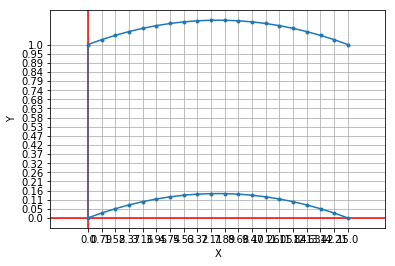

In [17]:
plotfig_simple(np.vstack((upper_arc, lower_arc)), draw_coord_lines=True)

In [18]:
# Зададим боковые линии
left_line = np.array([
    [stp[0], stp[1]],
    [stp[0], stp[1] + H]
])
right_line = np.array([
    [stp[0] + L, stp[1]],
    [stp[0] + L, stp[1] + H]
])
# Разобьем их (удалим крайние точки, т.к. они уже есть в арках)
left_line = split_border(left_line, SPLITNUM)[1:-1]
right_line = split_border(right_line, SPLITNUM)[1:-1]

# Развернем левую линию, чтобы она отрисовывалась сверху вниз, а не снизу-вверх
left_line = left_line[::-1]

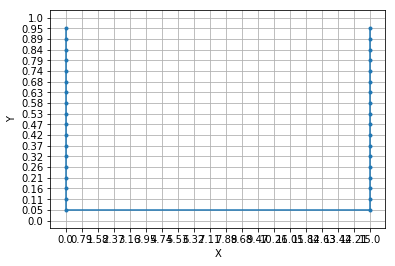

In [19]:
plotfig_simple(np.vstack((left_line, right_line)))

In [20]:
# And collect everything together
figure = np.vstack((lower_arc, right_line, upper_arc, left_line))

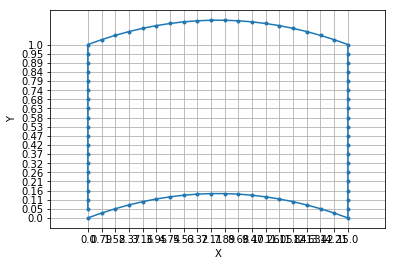

In [21]:
plotfig_simple(figure)

# Создадим разбиение полученной фигуры на треугольники

## Вначале определим сетку

In [22]:
#delta_x=0.5
#delta_y=0.01
#
#l = np.linspace(stp[0]+delta_x, stp[1]+L-delta_x, 45)
#h = np.linspace(stp[0]+delta_y, stp[1]+H-delta_y+0.1, 15)
#
#X, Y = np.meshgrid(l, h)

In [23]:
#inner = np.vstack((X.ravel(), Y.ravel())).T

In [24]:
# Arc-based net
net_row = lower_arc[1:-1]

resnet_x = np.zeros((SPLITNUM-1, net_row.shape[0]))
resnet_y = np.zeros((SPLITNUM-1, net_row.shape[0]))

for i in range(1,SPLITNUM):
    resnet_x[i-1] = net_row[:,0]
    resnet_y[i-1] = net_row[:,1]+i*(1./SPLITNUM)

inner = np.vstack((resnet_x.ravel(), resnet_y.ravel())).T

([<matplotlib.axis.XTick at 0x7f2acf9908d0>,
 <a list of 15 Text xticklabel objects>)

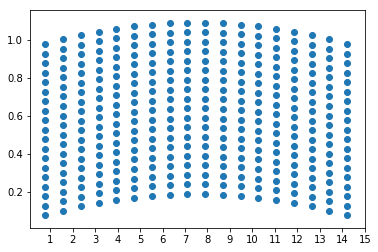

In [53]:
plt.scatter(inner[:,0], inner[:,1])
plt.xticks(np.arange(1, 16, 1))

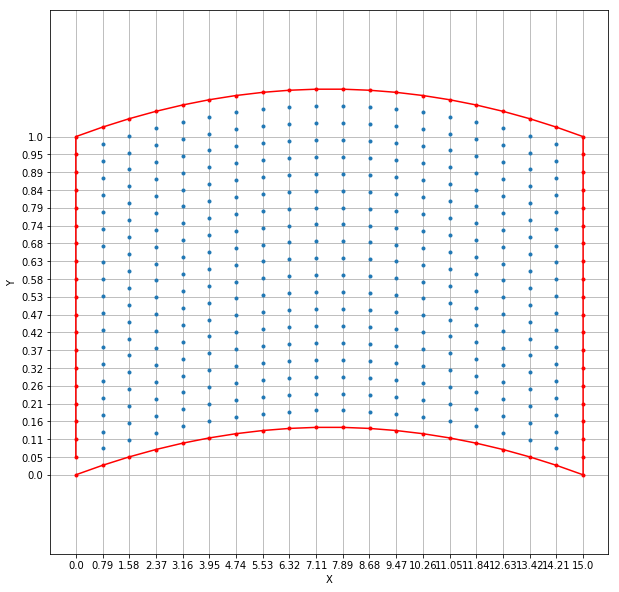

In [25]:
plt.figure(figsize=(10, 10))
plotfig_mesh(inner, figure)

## Применим маски для сетки

In [26]:
delta2_up = 0.0
delta2_low = 0.0
mask_net_upper = np.sum(np.power(inner - upper_circle_center, 2), axis=1) < (R-delta2_up)**2
mask_net_lower = np.sum(np.power(inner - lower_circle_center, 2), axis=1) > (R+delta2_low)**2

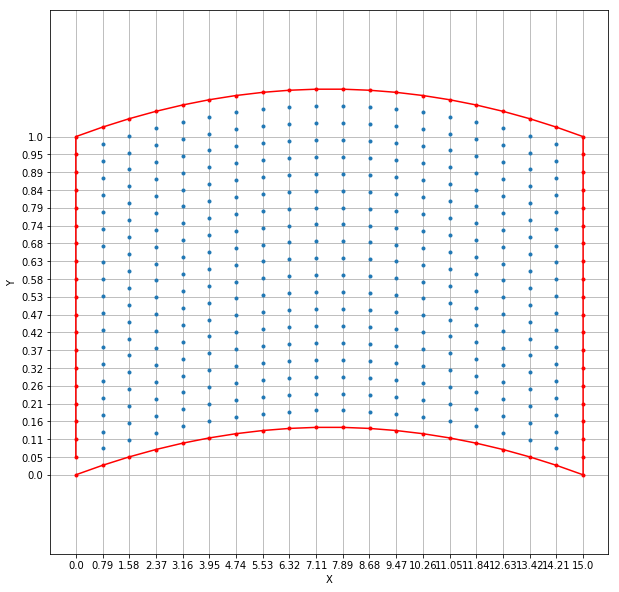

In [27]:
plt.figure(figsize=(10, 10))
plotfig_mesh(inner[mask_net_upper & mask_net_lower], figure)

In [28]:
inner_masked = inner[mask_net_upper & mask_net_lower]

In [54]:
np.sum(mask_net_lower)

342

In [55]:
mask_net_lower.shape

(342,)

In [56]:
np.sum(mask_net_upper)

342

In [57]:
mask_net_upper.shape

(342,)

## Применим триангуляцию

In [29]:
Nodes = np.vstack((figure, inner_masked))

In [30]:
trng = scipy.spatial.Delaunay(Nodes)

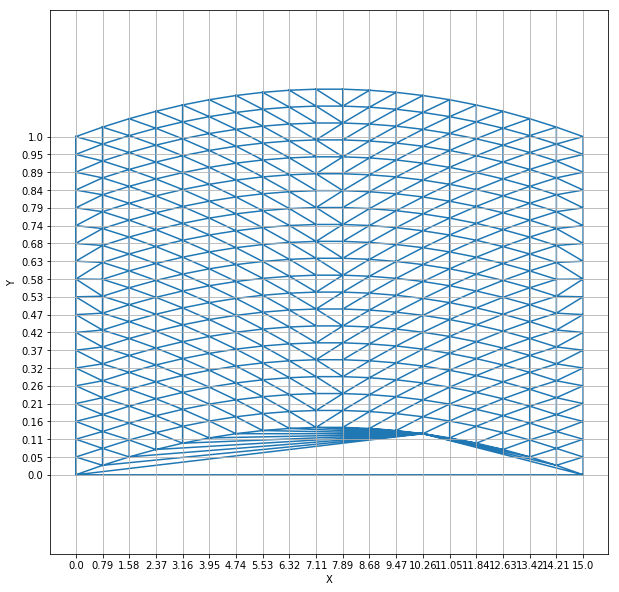

In [31]:
plt.figure(figsize=(10, 10))
plotfig_trng(Nodes, trng.simplices.copy())

In [32]:
trng_vertices = Nodes[trng.simplices.copy()]

trng_x_vertices = trng_vertices[:, :, 0]
trng_y_vertices = trng_vertices[:, :, 1]

trng_x_mean = np.mean(trng_x_vertices, axis=1)
trng_y_mean = np.mean(trng_y_vertices, axis=1)

trng_centers = np.hstack((trng_x_mean.reshape(-1, 1), trng_y_mean.reshape(-1, 1)))

In [33]:
delta3 = 0.0
mask_trng = np.sum(np.power(trng_centers - lower_circle_center, 2), axis=1) > (R+delta3)**2

In [34]:
simplices = trng.simplices.copy()
simplices = simplices[mask_trng]

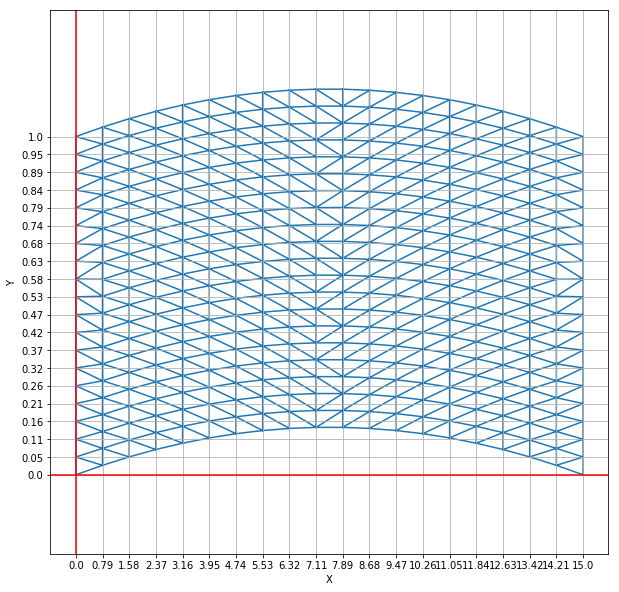

In [35]:
plt.figure(figsize=(10,10))
plotfig_trng(Nodes, simplices, draw_coord_lines=True)

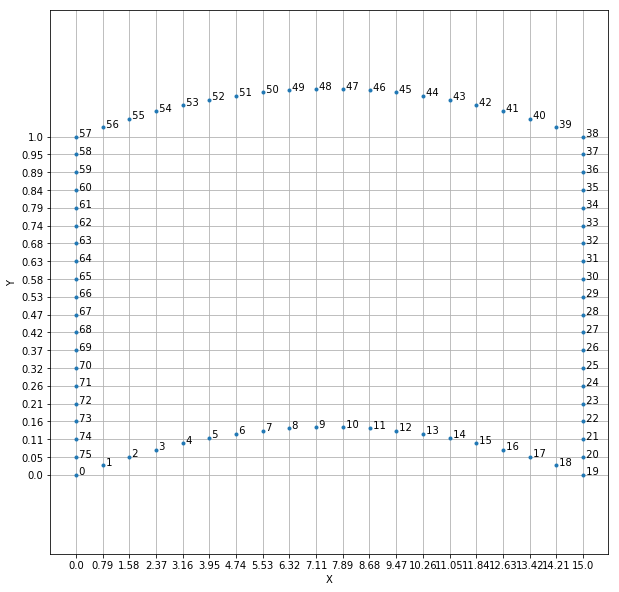

In [36]:
plt.figure(figsize=(10, 10))
plotfig_enumerate_border(figure)

In [72]:
_a = np.array([[1, 2, 3],[4, 5, 6]])
_a

array([[1, 2, 3],
       [4, 5, 6]])

In [75]:
np.where((_a == [4, 5, 6]).all(axis=1))

(array([1]),)

In [65]:
simplices.shape

(776, 3)

In [67]:
np.array([[63, 70, 79]]).shape

(1, 3)

In [76]:
np.where((simplices == [63, 70, 79]).all(axis=1))

(array([], dtype=int64),)

In [64]:
np.where()

array([238, 220, 221], dtype=int32)

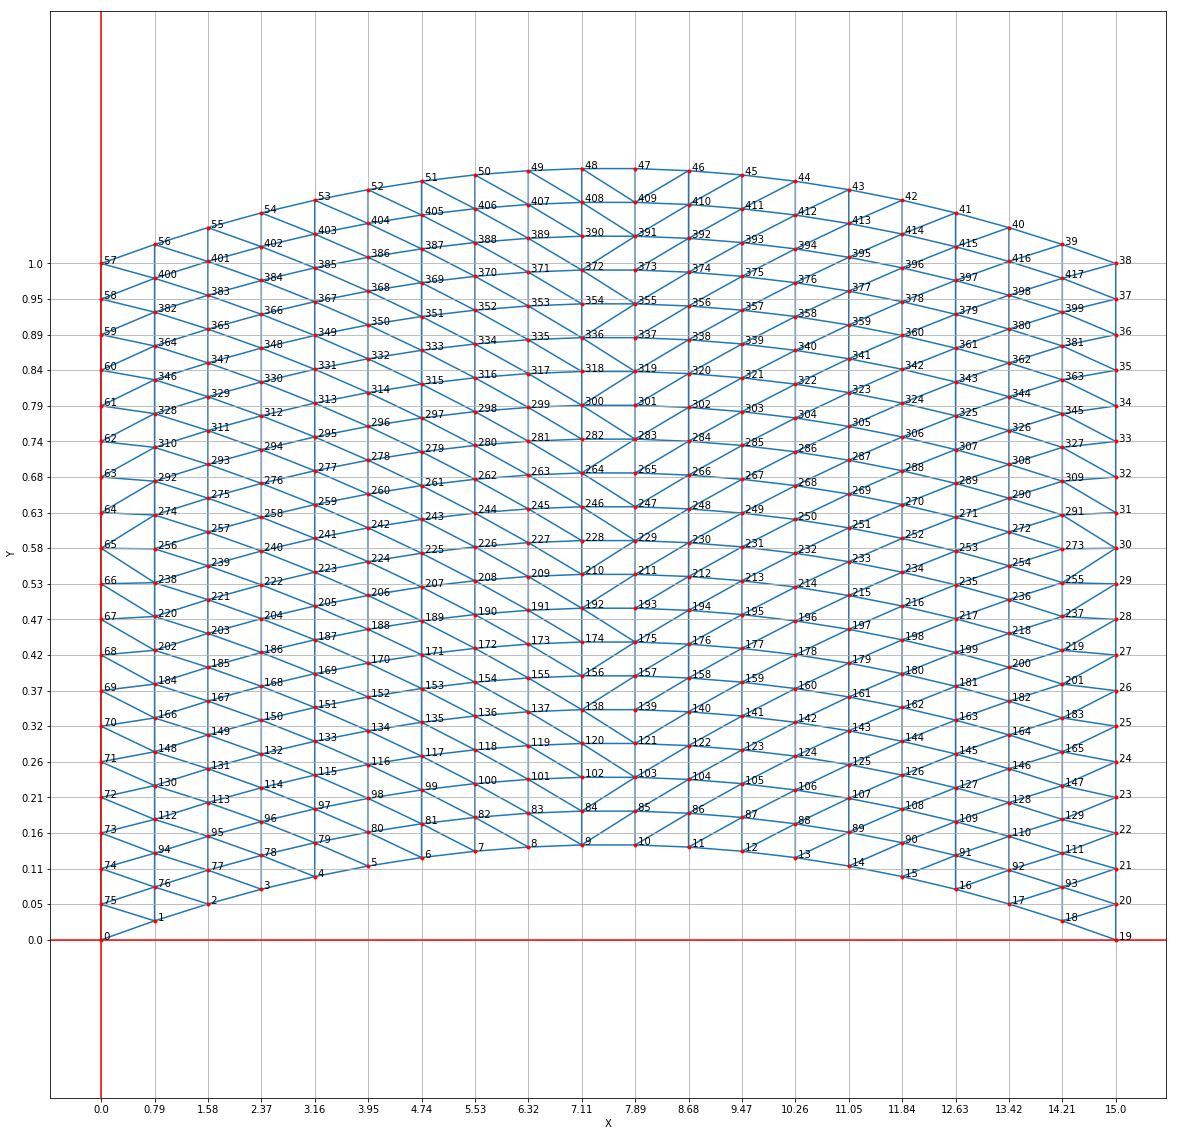

In [37]:
plt.figure(figsize=(20, 20))
plotfig_enumerate_trng(Nodes, simplices, draw_coord_lines=True)

In [38]:
# функция для вычисления площади элементов
def triarea(a, b, c):
    ab = b - a
    ac = c - a
    return 0.5 * (ab[:,0]*ac[:,1] - ab[:,1]*ac[:,0])

In [39]:
def sol(Nodes, simplices, constants, fixed_y, fixed_xy, forced_nodes, force_angle, debug=False):
    # Как делали на семинаре, рассчитаем:
    # 1. Матрицу градиентов B
    # 2. Глобальную матрицу жесткости
    # 3. Рассчитаем граничные условия и внесем их в МКЭ
    # 4. Рассчитаем перемещения элементов
    # 5. Найдем напряжения на элементах
    
    # -----> 1.<-----
    trng_vertices2 = Nodes[simplices] # Учитываем примененные к триангуляции маски и удалим ненужные точки
    A = triarea(trng_vertices2[:,0], trng_vertices2[:,1], trng_vertices2[:,2])
    b = trng_vertices2[:, [1,2,0], 1] - trng_vertices2[:, [2, 0, 1], 1]
    c = trng_vertices2[:, [2,0,1],0] - trng_vertices2[:,[1,2,0],0]
    z = np.zeros_like(b[:,0])
    #print(A)
    if len(A==0.0):
        if debug:
            print(">>> Array A has zero-valued triangle areas!")
            print(">>> Substituting these values with 1e-50")
        A[A == 0.0] = 1e-50
    
    zero_indexes = np.abs(A) < 1e-10
    print(zero_indexes)
    print(simplices[zero_indexes])
    
    B1 = np.stack((b[:,0], z, b[:,1], z, b[:,2], z), axis=1)
    B2 = np.stack((z, c[:,0], z, c[:,1], z, c[:,2]), axis=1)
    B3 = np.stack((c[:,0], b[:,0], c[:,1], b[:,1], c[:,2], b[:,2]), axis=1)
    B = np.stack((B1, B2, B3), axis=1)
    
    # -----> 2.<-----
    coef = 1.0/(2.0*A)   
    B *= coef.reshape(-1, 1, 1)

    # Константы
    E = constants['E']   # Модуль Юнга, Н/см^2
    mu = constants['mu'] # коэффициент Ламэ, безразмерный
    t = constants['t']   # Толщина детали, cm
    P = constants['P']   # Распределенное усилие, Н/см^2
    
    D = E / (1.0 - mu**2)*np.array([[1,mu,0], [mu,1,0], [0,0,0.5*(1.0-mu)]])
    BT = np.transpose(B, axes=(0,2,1))
    Ke = np.matmul(np.matmul(BT, D), B)*t*A.reshape(-1, 1, 1)

    # -----> 3.<-----
    coords0 = simplices[:, 0].reshape(-1, 1)
    coords1 = simplices[:, 1].reshape(-1, 1)
    coords2 = simplices[:, 2].reshape(-1, 1)
    
    EFT = np.hstack((coords0*2, coords0*2+1, coords1*2, coords1*2+1, coords2*2, coords2*2+1))
    Nn = Nodes.shape[0]
    K = np.zeros((2*Nn, 2*Nn))
    
    # i -- номер элемента
    for i in range(simplices.shape[0]):
        K[EFT[i, np.newaxis].T,EFT[i]] += Ke[i]
    
    # fixed_xy -- граничные узлы с нулевыми перемещениями по обеим степеням свободы
    # fixed_y -- граничные узлы с нулевым перемещением по оси Y
    dof = np.hstack((fixed_xy*2, fixed_xy*2+1, fixed_y*2+1))
    
    # занулить в матрице K строки с номерами dof[i]
    # занулить в матрице K столбцы с номерами dof[i]
    # матрице K поставить 1 на диагональ в позициях (dof[i], dof[i])
    K[dof, :] = 0
    K[:, dof] = 0
    K[dof, dof] = 1
    
    # Силы, действующие на элементы
    F = np.zeros(2*Nn)
    
    # Длины ребер, к которым приложено P
    force_node_coords = Nodes[forced_nodes]
    force_areas = np.sqrt(np.sum(np.power(force_node_coords[:-1] - force_node_coords[1:], 2), axis=1))
    
    # Направление силы по осям
    direction_x = np.sign(np.cos(np.deg2rad(force_angle)))
    direction_y = np.sign(np.sin(np.deg2rad(force_angle)))
    
    # Проекции силы по осям
    forces_x = force_areas * t * P * np.sin(np.deg2rad(90 - force_angle))
    forces_y = force_areas * t * P * np.cos(np.deg2rad(90 - force_angle))
    
    # Проверка
    if not(np.all(np.sign(forces_x) == direction_x) and np.all(np.sign(forces_y) == direction_y)):
        if debug:
            print("Force direction calculation is incorrect! Thatsa bug")
        return
    
    # Внутренние точки
    #F[forced_nodes[1:-1]*2] = 0.5*forces_x[1:] + 0.5*forces_x[:-1]
    #F[forced_nodes[1:-1]*2+1] = 0.5*forces_y[1:] + 0.5*forces_y[:-1]
    
    # Граничные точки
    #F[forced_nodes[0]*2] = 0.5*forces_x[0]
    #F[forced_nodes[-1]*2] = 0.5*forces_x[-1]
    #F[forced_nodes[0]*2+1] = 0.5*forces_y[0]
    #F[forced_nodes[-1]*2+1] = 0.5*forces_y[-1]
    F[forced_nodes[1:]*2] += 0.5 * force_areas*t*P*np.cos(np.deg2rad(force_angle))
    F[forced_nodes[1:]*2+1] += 0.5 * force_areas*t*P*np.sin(np.deg2rad(force_angle))
    F[forced_nodes[:-1]*2] += 0.5 * force_areas*t*P*np.cos(np.deg2rad(force_angle))
    F[forced_nodes[:-1]*2+1] += 0.5 * force_areas*t*P*np.sin(np.deg2rad(force_angle))
    
    F[dof] = 0
    
    # -----> 4.<-----
    # решение системы линейных уравнений K*U=F
    if not np.isfinite(K).all():
        if debug:
            print('Some values of an array are infinite or nan')
            print('Cannot solve system')
        return
    
    if debug:
        print("Solving system...")
        
    print(K[0])
    print(K[1])
    
    U = np.linalg.solve(K, F)
    
    # -----> 5.<-----
    Ue = U[EFT, None]
    Eps = np.matmul(B, Ue)
    Sig = np.matmul(D, Eps)
    
    NodeA = np.zeros((Nn,1))
    NodeSig = np.zeros((Nn,3))
    for i, e in enumerate(simplices):
        NodeSig[e] += Sig[i].T*A[i]
        NodeA[e] += A[i]
    NodeSig /= NodeA
    
    NodeS1 = 0.5*(NodeSig[:,0]+NodeSig[:,1])+\
         np.sqrt((0.5*(NodeSig[:,0]-NodeSig[:,1]))**2+NodeSig[:,2]**2)
    return U, NodeS1

# Оптимизационная задача

In [40]:
from scipy import optimize

In [41]:
def fun_to_optimize(P, forced_nodes, fixed_y, fixed_xy, force_angle, theta_T):
    # P (кг) --> P(Н/см^2)
    force_node_coords = Nodes[forced_nodes]
    force_area_all = np.sqrt(np.sum(np.power(force_node_coords[:-1] - force_node_coords[1:], 2)))
    P_H_cm2 = (P*9.81)/force_area_all
    
    constants = {
    'E':E,
    'mu':mu,
    't':t,
    'P':P_H_cm2
    }
    print(P)
    
    U, NodeS1 = sol(Nodes, simplices, constants, fixed_y, fixed_xy, forced_nodes, force_angle)
    return theta_T - np.max(np.abs(NodeS1))

In [42]:
forced_nodes = np.arange(38, 58)
fixed_y = np.array((0), dtype=int)
fixed_xy = np.array((19), dtype=int)
force_angle = -75 # Degrees
scipy.optimize.root(fun_to_optimize, x0=10., args=(forced_nodes, fixed_y, fixed_xy, force_angle, 9e4))

[10.]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

[10.]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

[10.00000015]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False 

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[564.30966602]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False

    fjac: array([[-1.]])
     fun: 5.820766091346741e-11
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-3.0559022e-10])
       r: array([372.13610202])
  status: 1
 success: True
       x: array([564.30966602])

# Решим задачу с найденным значением $P$

In [43]:
# def sol(Nodes, simplices, constants, fixed_y, fixed_xy, forced_nodes, force_angle, debug=False):

In [44]:
# Решим задачу с найденным значением P
P=564.30966602
forced_nodes = np.arange(38, 58)
force_node_coords = Nodes[forced_nodes]
force_area_all = np.sqrt(np.sum(np.power(force_node_coords[:-1] - force_node_coords[1:], 2)))
P_H_cm2 = (P*9.81)/force_area_all
print("PHcm^2 is {0}".format(P_H_cm2))
constants = {
    'E':E,
    'mu':mu,
    't':t,
    'P':P_H_cm2
}

fixed_y = np.array((0,), dtype=int)
fixed_xy = np.array((19,), dtype=int)

force_angle = -90 # Degrees
U, NodeS1 = sol(Nodes, simplices, constants, fixed_y, fixed_xy, forced_nodes, force_angle)

PHcm^2 is 1608.3126577031062
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False Fal

# Ответ на задачу

In [45]:
# Найдем max(U) для данного P
print("max(abs(U)) для данного профиля при условии сохранения упругой деформации: {0}".format(np.max(np.abs(U))))

max(abs(U)) для данного профиля при условии сохранения упругой деформации: 0.10816993608529867


In [46]:
U[0]

-1.8126937125319902e-17

# Визуализируем поведение детали при найденном $P$

In [47]:
scale = 1 # масштаб
resNodes = Nodes + scale*U.reshape(-1,2)

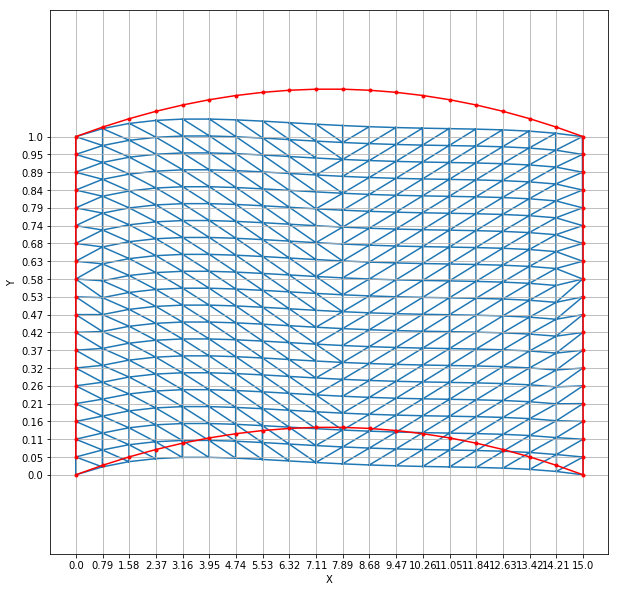

In [48]:
plt.figure(figsize=(10, 10))
plotfig_trng(resNodes, simplices, figure)

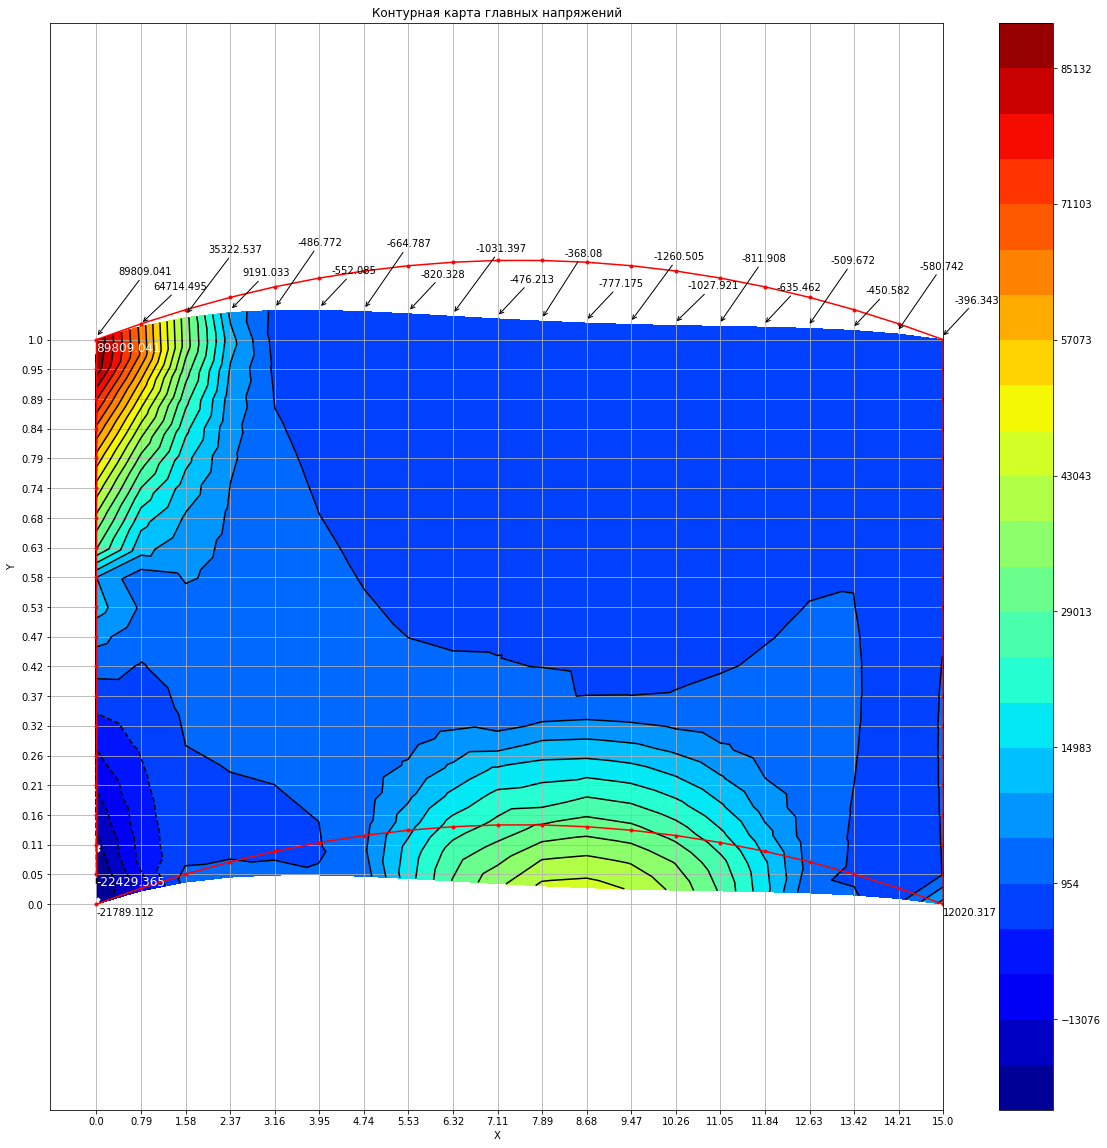

In [49]:
# (Nodes, simplices, resNodes, NodeS1, scale_coeff, fig_pts,  fixed_pts, force_pts, levels_cnt, scale_x=1., scale_y=10., draw_coord_lines=False):
plt.figure(figsize=(20, 20))
plot_fancy_thingy(Nodes, simplices, resNodes, NodeS1, figure, [0, 19], forced_nodes, 25)

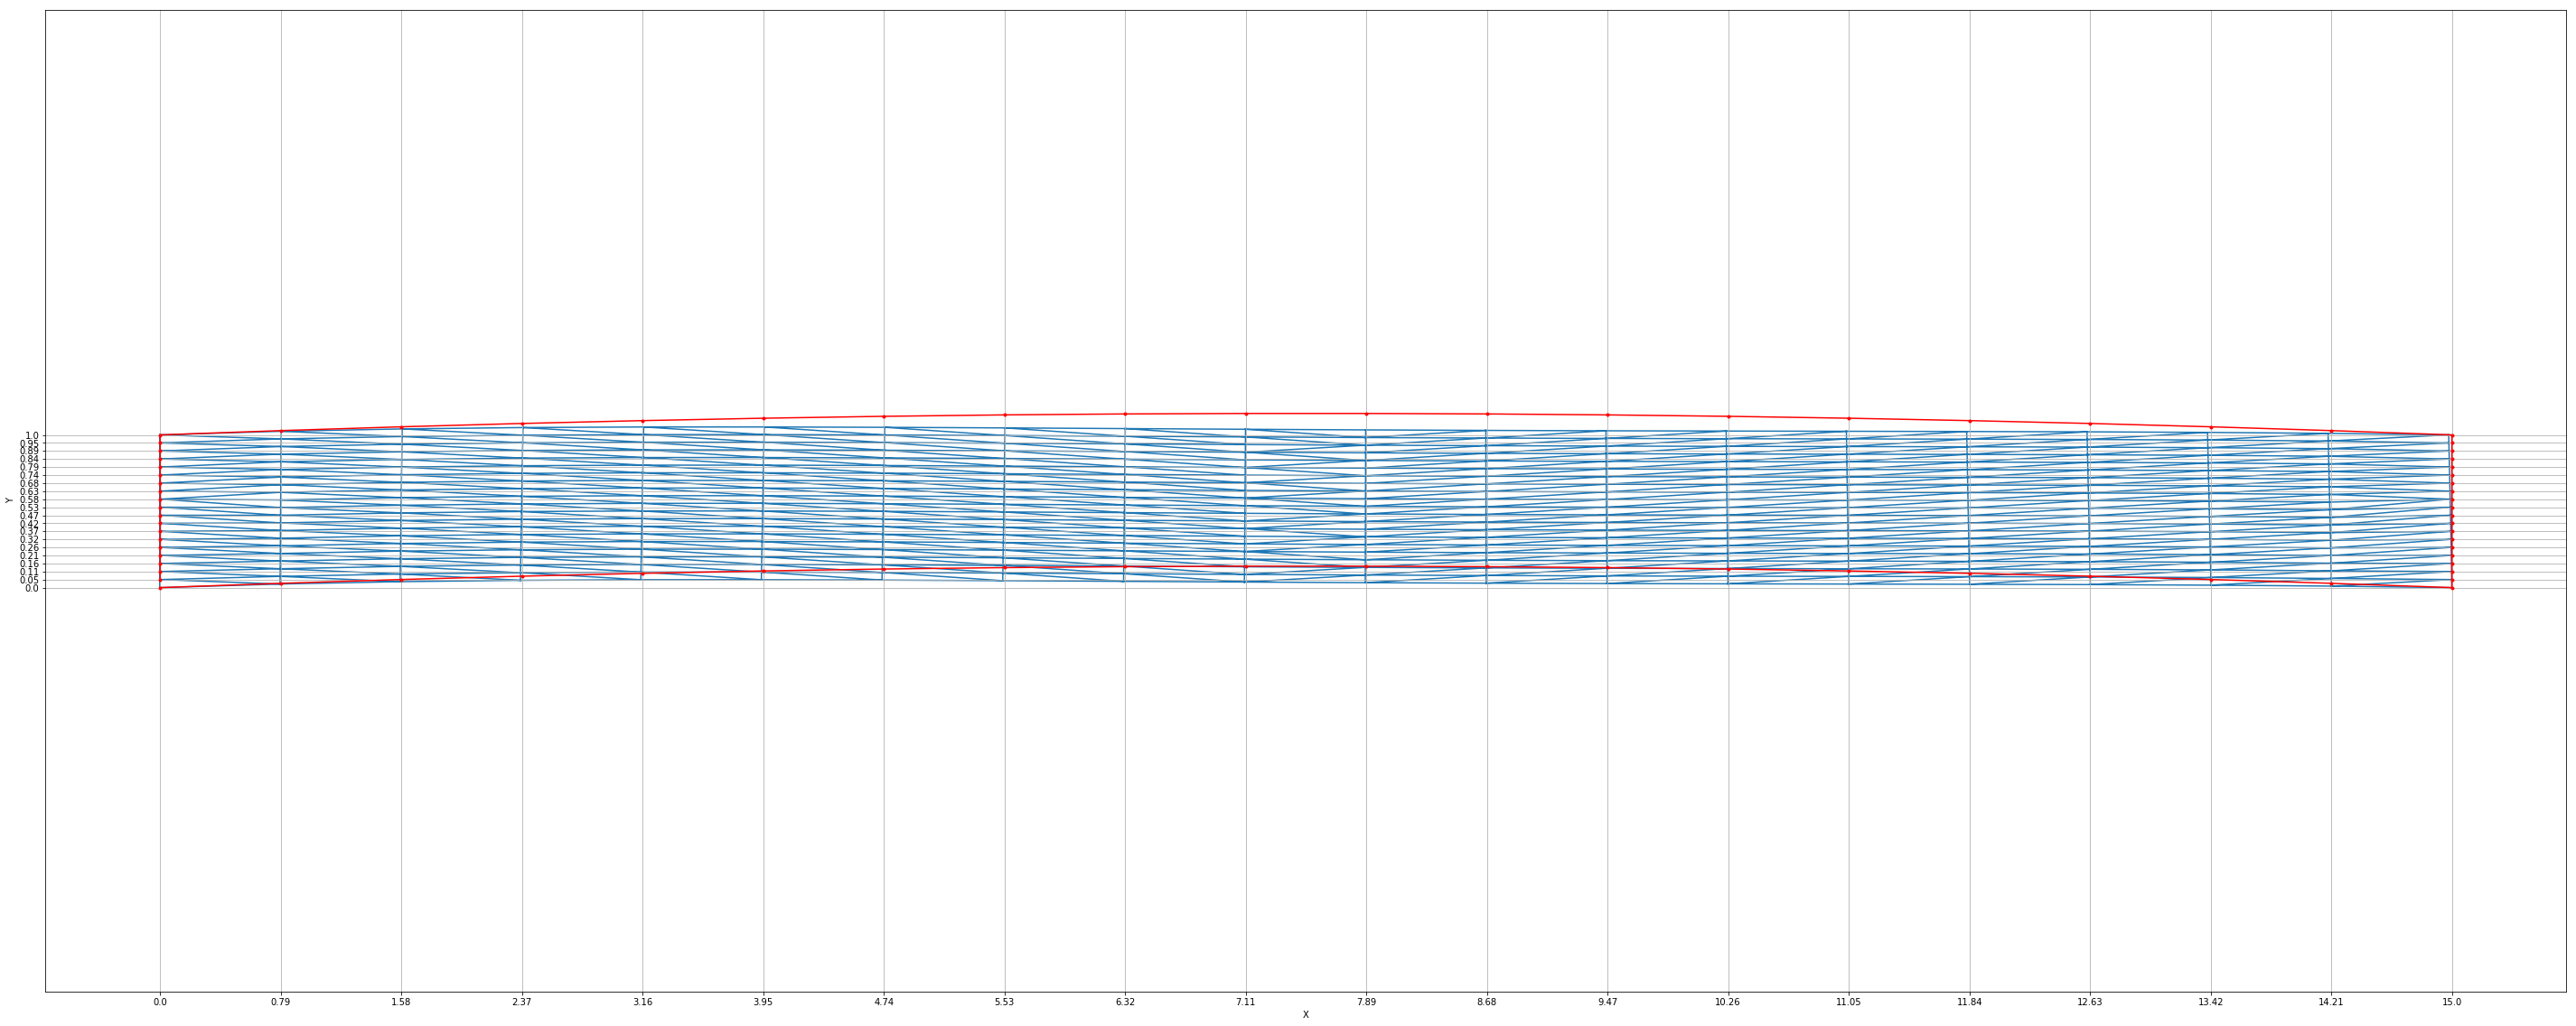

In [50]:
plt.figure(figsize=(50, 20))
plotfig_trng(resNodes, simplices, figure, scale_y=1)